<h2>1. Modelling and Comparison of Model Performance Based on Volume of Data</h2>

In [1]:
#Neo4j
#Extract data from Neo4j to pyspark dataframe for modelling
#Hive DB
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from neo4j import GraphDatabase

# Create a SparkSession
spark = SparkSession.builder \
    .appName("Modeling") \
    .config('spark.sql.warehouse.dir', 'hdfs:/user/hive/warehouse/')\
    .config("spark.sql.catalogImplementation", "hive")\
    .enableHiveSupport()\
    .getOrCreate()

# Define a function to read data from Neo4j into a PySpark DataFrame
    # Establish connection to Neo4j
graph = GraphDatabase.driver(uri="neo4j+s://46bd93aa.databases.neo4j.io", auth=("neo4j", "M2REJH20Eeod7AZ7n_lLZR4UjWLVacefdrvOE4vapKA"))
session = graph.session()

    # Define Cypher query to retrieve data
cypher_query = "MATCH (c:Combined) RETURN c.comment AS Comment, c.sentimentScore AS SentimentScore, c.sentiment AS Sentiment"

    # Execute Cypher query and retrieve results
result = session.run(cypher_query)

    # Store the results in a list of dictionaries
data = [{"Comment": record["Comment"], "SentimentScore": record["SentimentScore"], "Sentiment": record["Sentiment"]} for record in result]

    # Close the session
session.close()

24/04/27 05:03:32 WARN Utils: Your hostname, jupy-06 resolves to a loopback address: 127.0.1.1; using 10.123.51.206 instead (on interface ens18)
24/04/27 05:03:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/27 05:03:32 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/04/27 05:03:33 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
neo4j_df = spark.createDataFrame(data)

# Show the DataFrame
neo4j_df.show()

total_count = neo4j_df.count()
print("Total count of data:", total_count)

24/04/27 05:03:39 WARN DomainSocketFactory: The short-circuit local reads feature cannot be used because libhadoop cannot be loaded.


+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|its not at all p ...| Negative|        -0.296|
|there is no way t...| Positive|        0.1071|
|codm isnt p w  ca...|  Neutral|           0.0|
|i don t think  th...| Positive|        0.9857|
|it s not really a...| Positive|        0.5848|
|which bp vault gu...| Positive|        0.0258|
|it s expressing h...| Negative|       -0.0772|
|the vast majority...| Positive|        0.7964|
|half true  it exi...| Positive|        0.6908|
|thanks for the tl...| Positive|        0.4749|
|   you had  one  job|  Neutral|           0.0|
|i m surprised you...| Positive|        0.8963|
|the grau does  th...| Positive|        0.9485|
|obviously  if the...| Negative|       -0.4019|
|    pretty much yeah| Positive|        0.6597|
|i really  really ...| Negative|       -0.7963|
|which is the same...| Positive|        0.9022|
|                most|  Neutral|        

In [3]:
#df for modeling
df_modeling = neo4j_df
df_modeling.show()

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|its not at all p ...| Negative|        -0.296|
|there is no way t...| Positive|        0.1071|
|codm isnt p w  ca...|  Neutral|           0.0|
|i don t think  th...| Positive|        0.9857|
|it s not really a...| Positive|        0.5848|
|which bp vault gu...| Positive|        0.0258|
|it s expressing h...| Negative|       -0.0772|
|the vast majority...| Positive|        0.7964|
|half true  it exi...| Positive|        0.6908|
|thanks for the tl...| Positive|        0.4749|
|   you had  one  job|  Neutral|           0.0|
|i m surprised you...| Positive|        0.8963|
|the grau does  th...| Positive|        0.9485|
|obviously  if the...| Negative|       -0.4019|
|    pretty much yeah| Positive|        0.6597|
|i really  really ...| Negative|       -0.7963|
|which is the same...| Positive|        0.9022|
|                most|  Neutral|        

In [4]:
from pyspark.sql.functions import col
df_modeling.filter(col('Comment') == 'None').count()

54

In [5]:
df_modeling = df_modeling.filter(col('Comment') != 'None')

In [6]:
print("No of records:", df_modeling.count())

No of records: 5987


<h3>1.1 EXPERIMENT 1 (80% of data used for training)</h3>

In [7]:
#random split data
train_data, test_data = df_modeling.randomSplit([0.8, 0.2], seed=1234)  # 80% training, 20% testing
train_data.printSchema()
test_data.printSchema()

root
 |-- Comment: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- SentimentScore: double (nullable = true)

root
 |-- Comment: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- SentimentScore: double (nullable = true)



In [8]:
#Store to hive
spark.sql("CREATE DATABASE IF NOT EXISTS sentiment_data")
spark.sql("SHOW DATABASES").show()

spark.sql('USE sentiment_data')
tables = spark.sql("SHOW TABLES").show()

# Check current database
spark.catalog.currentDatabase()

+--------------+
|     namespace|
+--------------+
|       default|
|  g31_sales_db|
|          hrdb|
|       salesdb|
|sentiment_data|
+--------------+

+--------------+--------------------+-----------+
|     namespace|           tableName|isTemporary|
+--------------+--------------------+-----------+
|sentiment_data|   prediction_result|      false|
|sentiment_data|prediction_result...|      false|
|sentiment_data|      temp_csv_table|      false|
|sentiment_data|           test_data|      false|
|sentiment_data|          train_data|      false|
|sentiment_data|      train_data_eva|      false|
+--------------+--------------------+-----------+



'sentiment_data'

In [9]:
spark.sql("DROP TABLE IF EXISTS sentiment_data.train_data")
spark.sql("DROP TABLE IF EXISTS sentiment_data.test_data")
spark.sql("DROP TABLE IF EXISTS sentiment_data.prediction_result")

spark.sql("CREATE TABLE sentiment_data.train_data (Comment STRING, Sentiment STRING, SentimentScore DOUBLE)")
spark.sql("CREATE TABLE sentiment_data.test_data (Comment STRING, Sentiment STRING, SentimentScore DOUBLE)")
spark.sql("SHOW TABLES").show()

24/04/27 05:03:59 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
24/04/27 05:04:00 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


+--------------+--------------------+-----------+
|     namespace|           tableName|isTemporary|
+--------------+--------------------+-----------+
|sentiment_data|prediction_result...|      false|
|sentiment_data|      temp_csv_table|      false|
|sentiment_data|           test_data|      false|
|sentiment_data|          train_data|      false|
|sentiment_data|      train_data_eva|      false|
+--------------+--------------------+-----------+



24/04/27 05:04:00 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.


In [10]:
train_df = train_data
train_df.show()

test_df = test_data
test_df.show()

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|a gun with    met...| Negative|       -0.9137|
|a lotjk but you l...| Positive|        0.4215|
|a man of culture ...|  Neutral|           0.0|
|     about damn time| Negative|       -0.4019|
|about time we fin...| Positive|          0.34|
|absolute legend  ...| Negative|       -0.3412|
|abuse the perk so...| Negative|       -0.6369|
|acog  or the amou...| Positive|        0.4939|
|actually you ll b...| Positive|        0.4404|
|after so long not...|  Neutral|           0.0|
|agree  but someti...| Negative|       -0.4019|
|agree  i for exam...| Negative|         -0.34|
|agreed  some peop...| Positive|        0.5719|
|          ah  thanks| Positive|        0.4404|
|alcatraz  tait tr...|  Neutral|           0.0|
|            alert op| Positive|         0.296|
|all of your contr...| Positive|        0.1779|
|almost seems to b...| Positive|        

In [11]:
print("No of records in training dataset:", train_df.count())

No of records in training dataset: 4811


In [12]:
train_df.show(2)

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|a gun with    met...| Negative|       -0.9137|
|a lotjk but you l...| Positive|        0.4215|
+--------------------+---------+--------------+
only showing top 2 rows



In [13]:
print("No of records in testing dataset:", test_df.count())

No of records in testing dataset: 1176


In [14]:
train_df.createOrReplaceTempView("train_view")
test_df.createOrReplaceTempView("test_view")
spark.sql("SELECT * FROM train_view").show()
spark.sql("SELECT * FROM test_view").show()

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|a gun with    met...| Negative|       -0.9137|
|a lotjk but you l...| Positive|        0.4215|
|a man of culture ...|  Neutral|           0.0|
|     about damn time| Negative|       -0.4019|
|about time we fin...| Positive|          0.34|
|absolute legend  ...| Negative|       -0.3412|
|abuse the perk so...| Negative|       -0.6369|
|acog  or the amou...| Positive|        0.4939|
|actually you ll b...| Positive|        0.4404|
|after so long not...|  Neutral|           0.0|
|agree  but someti...| Negative|       -0.4019|
|agree  i for exam...| Negative|         -0.34|
|agreed  some peop...| Positive|        0.5719|
|          ah  thanks| Positive|        0.4404|
|alcatraz  tait tr...|  Neutral|           0.0|
|            alert op| Positive|         0.296|
|all of your contr...| Positive|        0.1779|
|almost seems to b...| Positive|        

In [15]:
spark.sql("INSERT INTO TABLE  sentiment_data.train_data  SELECT * FROM train_view")
spark.sql("INSERT INTO TABLE  sentiment_data.test_data  SELECT * FROM test_view")

DataFrame[]

In [16]:
# View data from train_data, test_data table
# spark.sql("SELECT * FROM sentiment_data.train_data").show()
# spark.sql("SELECT * FROM sentiment_data.test_data").show()

In [17]:
#craw data from hive and to modeling
train_data = spark.sql("SELECT * FROM sentiment_data.train_data")
train_data.show()
test_data = spark.sql("SELECT * FROM sentiment_data.test_data")
test_data.show()

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|a gun with    met...| Negative|       -0.9137|
|a lotjk but you l...| Positive|        0.4215|
|a man of culture ...|  Neutral|           0.0|
|     about damn time| Negative|       -0.4019|
|about time we fin...| Positive|          0.34|
|absolute legend  ...| Negative|       -0.3412|
|abuse the perk so...| Negative|       -0.6369|
|acog  or the amou...| Positive|        0.4939|
|actually you ll b...| Positive|        0.4404|
|after so long not...|  Neutral|           0.0|
|agree  but someti...| Negative|       -0.4019|
|agree  i for exam...| Negative|         -0.34|
|agreed  some peop...| Positive|        0.5719|
|          ah  thanks| Positive|        0.4404|
|alcatraz  tait tr...|  Neutral|           0.0|
|            alert op| Positive|         0.296|
|all of your contr...| Positive|        0.1779|
|almost seems to b...| Positive|        

In [18]:
#start modeling
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [19]:
# preprocess & retokenize - train data
tokenizer = Tokenizer(inputCol="Comment", outputCol="words")
words_data = tokenizer.transform(train_data)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
final_data = idf_model.transform(featurized_data)

In [20]:
#encode label column - train
indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
final_train_data = indexer.fit(final_data).transform(final_data)
final_train_data.show()

+--------------------+---------+--------------+--------------------+--------------------+--------------------+-----+
|             Comment|Sentiment|SentimentScore|               words|         rawFeatures|            features|label|
+--------------------+---------+--------------+--------------------+--------------------+--------------------+-----+
|a gun with    met...| Negative|       -0.9137|[a, gun, with, , ...|(10000,[1481,1756...|(10000,[1481,1756...|  1.0|
|a lotjk but you l...| Positive|        0.4215|[a, lotjk, but, y...|(10000,[346,488,6...|(10000,[346,488,6...|  0.0|
|a man of culture ...|  Neutral|           0.0|[a, man, of, cult...|(10000,[1756,2569...|(10000,[1756,2569...|  2.0|
|     about damn time| Negative|       -0.4019| [about, damn, time]|(10000,[3998,4956...|(10000,[3998,4956...|  1.0|
|about time we fin...| Positive|          0.34|[about, time, we,...|(10000,[488,1588,...|(10000,[488,1588,...|  0.0|
|absolute legend  ...| Negative|       -0.3412|[absolute, legend

In [21]:
# preprocess & retokenize - test data
tokenizer = Tokenizer(inputCol="Comment", outputCol="words")
words_data = tokenizer.transform(test_data)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
final_data = idf_model.transform(featurized_data)

In [22]:
#encode label column - test
indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
final_test_data = indexer.fit(final_data).transform(final_data)
final_test_data.show()

+--------------------+---------+--------------+--------------------+--------------------+--------------------+-----+
|             Comment|Sentiment|SentimentScore|               words|         rawFeatures|            features|label|
+--------------------+---------+--------------+--------------------+--------------------+--------------------+-----+
|a gun with    met...| Negative|       -0.9062|[a, gun, with, , ...|(10000,[73,165,19...|(10000,[73,165,19...|  1.0|
|a ww  mythic with...| Negative|       -0.4767|[a, ww, , mythic,...|(10000,[488,608,1...|(10000,[488,608,1...|  1.0|
|already a w  alth...|  Neutral|           0.0|[already, a, w, ,...|(10000,[211,594,1...|(10000,[211,594,1...|  2.0|
|              always|  Neutral|           0.0|            [always]|(10000,[9011],[1.0])|(10000,[9011],[2....|  2.0|
|am i the only one...| Positive|        0.7964|[am, i, the, only...|(10000,[66,80,307...|(10000,[66,80,307...|  0.0|
|american college ...|  Neutral|           0.0|[american, colleg

<h4>Logistic Regression:</h4>

In [23]:
#define model
lr = LogisticRegression(featuresCol="features", labelCol="label")

In [24]:
#create pipeline
pipeline = Pipeline(stages=[lr])

In [25]:
#Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [26]:
#define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")


In [27]:
#Define cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)


In [28]:
#Run cross-validation
cv_model = crossval.fit(final_train_data)

24/04/27 05:04:43 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [29]:
#get best model
best_model = cv_model.bestModel

In [30]:
# prediction
predictions = best_model.transform(final_test_data)

<h4>Test Accuracy:</h4>

In [31]:
#Evaluate the model
v1_accuracy = evaluator.evaluate(predictions)
print("Test Accuracy = {:.2f}%".format(v1_accuracy * 100))

Test Accuracy = 79.85%


<h4>Predictions:</h4>

In [32]:
#prediction result
predictions.select("Comment", "Sentiment", "prediction").show(truncate=True)
prediction_result = predictions.select("Comment", "Sentiment", "prediction")
# prediction_result.show(truncate=True)
prediction_result.printSchema()

+--------------------+---------+----------+
|             Comment|Sentiment|prediction|
+--------------------+---------+----------+
|a gun with    met...| Negative|       1.0|
|a ww  mythic with...| Negative|       2.0|
|already a w  alth...|  Neutral|       2.0|
|              always|  Neutral|       2.0|
|am i the only one...| Positive|       0.0|
|american college ...|  Neutral|       2.0|
|among ars i feel ...| Positive|       0.0|
|and we appreciate...| Positive|       2.0|
|appearently it s ...|  Neutral|       2.0|
|are we ever getti...| Positive|       0.0|
|as a persistence ...| Positive|       0.0|
|as long as there ...| Positive|       0.0|
|as long as there ...|  Neutral|       0.0|
|asks redditors fo...| Positive|       0.0|
|ay another loose ...| Negative|       1.0|
|because i m a dum...| Negative|       2.0|
|best record for l...| Positive|       0.0|
|better not  buttt...| Negative|       0.0|
|   bot match invites| Positive|       2.0|
|bro is going to d...|  Neutral|

<h4>Classification Report (Positive & Negative Classes):</h4>

In [33]:
# Calculate true positives for label 0
true_positives_0 = predictions.filter((predictions.label == 0) & (predictions.prediction == 0)).count()

# Calculate false positives for label 0
false_positives_0 = predictions.filter((predictions.label != 0) & (predictions.prediction == 0)).count()

# Calculate false negatives for label 0
false_negatives_0 = predictions.filter((predictions.label == 0) & (predictions.prediction != 0)).count()

# Calculate precision, recall, and F1-score for label 0
v1_precision_0 = true_positives_0 / (true_positives_0 + false_positives_0)
v1_recall_0 = true_positives_0 / (true_positives_0 + false_negatives_0)
v1_f1_score_0 = 2 * (v1_precision_0 * v1_recall_0) / (v1_precision_0 + v1_recall_0)

# Calculate true positives for label 1
true_positives_1 = predictions.filter((predictions.label == 1) & (predictions.prediction == 1)).count()

# Calculate false positives for label 1
false_positives_1 = predictions.filter((predictions.label != 1) & (predictions.prediction == 1)).count()

# Calculate false negatives for label 1
false_negatives_1 = predictions.filter((predictions.label == 1) & (predictions.prediction != 1)).count()

# Calculate precision, recall, and F1-score for label 1
v1_precision_1 = true_positives_1 / (true_positives_1 + false_positives_1)
v1_recall_1 = true_positives_1 / (true_positives_1 + false_negatives_1)
v1_f1_score_1 = 2 * (v1_precision_1 * v1_recall_1) / (v1_precision_1 + v1_recall_1)

# Calculate true positives for label 2
true_positives_2 = predictions.filter((predictions.label == 2) & (predictions.prediction == 2)).count()

# Calculate false positives for label 2
false_positives_2 = predictions.filter((predictions.label != 2) & (predictions.prediction == 2)).count()

# Calculate false negatives for label 2
false_negatives_2 = predictions.filter((predictions.label == 2) & (predictions.prediction != 2)).count()

# Calculate precision, recall, and F1-score for label 2
v1_precision_2 = true_positives_2 / (true_positives_2 + false_positives_2)
v1_recall_2 = true_positives_2 / (true_positives_2 + false_negatives_2)
v1_f1_score_2 = 2 * (v1_precision_2 * v1_recall_2) / (v1_precision_2 + v1_recall_2)

# Display classification report
print("Label 0 (Positive):")
print("Precision:", v1_precision_0)
print("Recall:", v1_recall_0)
print("F1-score:", v1_f1_score_0)

print("\nLabel 1 (Negative):")
print("Precision:", v1_precision_1)
print("Recall:", v1_recall_1)
print("F1-score:", v1_f1_score_1)

print("\nLabel 2 (Neutral):")
print("Precision:", v1_precision_2)
print("Recall:", v1_recall_2)
print("F1-score:", v1_f1_score_2)


Label 0 (Positive):
Precision: 0.8174123337363967
Recall: 0.9197278911564626
F1-score: 0.8655569782330347

Label 1 (Negative):
Precision: 0.7571428571428571
Recall: 0.5389830508474577
F1-score: 0.6297029702970296

Label 2 (Neutral):
Precision: 0.7482014388489209
Recall: 0.7123287671232876
F1-score: 0.7298245614035087


<h4>Confusion Matrix</h4>

In [34]:
from pyspark.sql.functions import expr

# Calculate confusion matrix
confusion_matrix = predictions.groupBy("label").pivot("prediction").count().fillna(0)

# Display confusion matrix
confusion_matrix.show()

+-----+---+---+---+
|label|0.0|1.0|2.0|
+-----+---+---+---+
|  0.0|676| 42| 17|
|  1.0|118|159| 18|
|  2.0| 33|  9|104|
+-----+---+---+---+



In [35]:
#store prediction result into hive
spark.sql("DROP TABLE IF EXISTS sentiment_data.prediction_result")

spark.sql("CREATE TABLE sentiment_data.prediction_result (Comment STRING, Sentiment STRING, prediction DOUBLE)")
spark.sql("SHOW TABLES").show()

+--------------+--------------------+-----------+
|     namespace|           tableName|isTemporary|
+--------------+--------------------+-----------+
|sentiment_data|   prediction_result|      false|
|sentiment_data|prediction_result...|      false|
|sentiment_data|      temp_csv_table|      false|
|sentiment_data|           test_data|      false|
|sentiment_data|          train_data|      false|
|sentiment_data|      train_data_eva|      false|
|              |           test_view|       true|
|              |          train_view|       true|
+--------------+--------------------+-----------+



24/04/27 05:06:24 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.


In [36]:
# spark.sql("DROP VIEW IF EXISTS prediction_result")
prediction_result.createOrReplaceTempView("prediction_result_view")
spark.sql("SELECT * FROM prediction_result_view").show()

+--------------------+---------+----------+
|             Comment|Sentiment|prediction|
+--------------------+---------+----------+
|a gun with    met...| Negative|       1.0|
|a ww  mythic with...| Negative|       2.0|
|already a w  alth...|  Neutral|       2.0|
|              always|  Neutral|       2.0|
|am i the only one...| Positive|       0.0|
|american college ...|  Neutral|       2.0|
|among ars i feel ...| Positive|       0.0|
|and we appreciate...| Positive|       2.0|
|appearently it s ...|  Neutral|       2.0|
|are we ever getti...| Positive|       0.0|
|as a persistence ...| Positive|       0.0|
|as long as there ...| Positive|       0.0|
|as long as there ...|  Neutral|       0.0|
|asks redditors fo...| Positive|       0.0|
|ay another loose ...| Negative|       1.0|
|because i m a dum...| Negative|       2.0|
|best record for l...| Positive|       0.0|
|better not  buttt...| Negative|       0.0|
|   bot match invites| Positive|       2.0|
|bro is going to d...|  Neutral|

In [37]:
#store prediction result into hive
spark.sql("INSERT INTO TABLE  sentiment_data.prediction_result  SELECT * FROM prediction_result_view")

DataFrame[]

In [38]:
prediction_result = spark.sql("SELECT * FROM sentiment_data.prediction_result")
prediction_result.show()

+--------------------+---------+----------+
|             Comment|Sentiment|prediction|
+--------------------+---------+----------+
|a gun with    met...| Negative|       1.0|
|a ww  mythic with...| Negative|       2.0|
|already a w  alth...|  Neutral|       2.0|
|              always|  Neutral|       2.0|
|am i the only one...| Positive|       0.0|
|american college ...|  Neutral|       2.0|
|among ars i feel ...| Positive|       0.0|
|and we appreciate...| Positive|       2.0|
|appearently it s ...|  Neutral|       2.0|
|are we ever getti...| Positive|       0.0|
|as a persistence ...| Positive|       0.0|
|as long as there ...| Positive|       0.0|
|as long as there ...|  Neutral|       0.0|
|asks redditors fo...| Positive|       0.0|
|ay another loose ...| Negative|       1.0|
|because i m a dum...| Negative|       2.0|
|best record for l...| Positive|       0.0|
|better not  buttt...| Negative|       0.0|
|   bot match invites| Positive|       2.0|
|bro is going to d...|  Neutral|

<h3>1.2 EXPERIMENT 2 (64% of data used for training)</h3>

In [39]:
#Evaluation
#random split data
train_data_eva, test_data_eva = train_data.randomSplit([0.8, 0.2], seed=1234)  
train_data_eva.printSchema()

root
 |-- Comment: string (nullable = true)
 |-- Sentiment: string (nullable = true)
 |-- SentimentScore: double (nullable = true)



In [40]:
train_df_eva = train_data_eva
train_df_eva.show()

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|a gun with    met...| Negative|       -0.9137|
|a man of culture ...|  Neutral|           0.0|
|     about damn time| Negative|       -0.4019|
|absolute legend  ...| Negative|       -0.3412|
|abuse the perk so...| Negative|       -0.6369|
|acog  or the amou...| Positive|        0.4939|
|actually you ll b...| Positive|        0.4404|
|after so long not...|  Neutral|           0.0|
|agree  but someti...| Negative|       -0.4019|
|agree  i for exam...| Negative|         -0.34|
|agreed  some peop...| Positive|        0.5719|
|          ah  thanks| Positive|        0.4404|
|alcatraz  tait tr...|  Neutral|           0.0|
|            alert op| Positive|         0.296|
|all of your contr...| Positive|        0.1779|
|almost seems to b...| Positive|        0.3214|
|alr ill make sure...| Negative|        -0.128|
|also   waiting fo...| Negative|       -

In [41]:
print("No of records in training dataset:", train_df_eva.count())

No of records in training dataset: 3855


In [42]:
print("No of records in testing dataset:", test_df.count())

No of records in testing dataset: 1176


In [43]:
spark.sql("DROP TABLE IF EXISTS sentiment_data.train_data_eva")

spark.sql("CREATE TABLE sentiment_data.train_data_eva (Comment STRING, Sentiment STRING, SentimentScore DOUBLE)")
spark.sql("SHOW TABLES").show()

+--------------+--------------------+-----------+
|     namespace|           tableName|isTemporary|
+--------------+--------------------+-----------+
|sentiment_data|   prediction_result|      false|
|sentiment_data|prediction_result...|      false|
|sentiment_data|      temp_csv_table|      false|
|sentiment_data|           test_data|      false|
|sentiment_data|          train_data|      false|
|sentiment_data|      train_data_eva|      false|
|              |prediction_result...|       true|
|              |           test_view|       true|
|              |          train_view|       true|
+--------------+--------------------+-----------+



24/04/27 05:06:38 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.


In [44]:
train_df_eva.createOrReplaceTempView("train_eva_view")
spark.sql("SELECT * FROM train_eva_view").show()

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|a gun with    met...| Negative|       -0.9137|
|a man of culture ...|  Neutral|           0.0|
|     about damn time| Negative|       -0.4019|
|absolute legend  ...| Negative|       -0.3412|
|abuse the perk so...| Negative|       -0.6369|
|acog  or the amou...| Positive|        0.4939|
|actually you ll b...| Positive|        0.4404|
|after so long not...|  Neutral|           0.0|
|agree  but someti...| Negative|       -0.4019|
|agree  i for exam...| Negative|         -0.34|
|agreed  some peop...| Positive|        0.5719|
|          ah  thanks| Positive|        0.4404|
|alcatraz  tait tr...|  Neutral|           0.0|
|            alert op| Positive|         0.296|
|all of your contr...| Positive|        0.1779|
|almost seems to b...| Positive|        0.3214|
|alr ill make sure...| Negative|        -0.128|
|also   waiting fo...| Negative|       -

In [45]:
spark.sql("INSERT INTO TABLE  sentiment_data.train_data_eva  SELECT * FROM train_eva_view")


DataFrame[]

In [46]:
train_data_eva = spark.sql("SELECT * FROM sentiment_data.train_data_eva")
train_data_eva.show()

+--------------------+---------+--------------+
|             Comment|Sentiment|SentimentScore|
+--------------------+---------+--------------+
|a gun with    met...| Negative|       -0.9137|
|a man of culture ...|  Neutral|           0.0|
|     about damn time| Negative|       -0.4019|
|absolute legend  ...| Negative|       -0.3412|
|abuse the perk so...| Negative|       -0.6369|
|acog  or the amou...| Positive|        0.4939|
|actually you ll b...| Positive|        0.4404|
|after so long not...|  Neutral|           0.0|
|agree  but someti...| Negative|       -0.4019|
|agree  i for exam...| Negative|         -0.34|
|agreed  some peop...| Positive|        0.5719|
|          ah  thanks| Positive|        0.4404|
|alcatraz  tait tr...|  Neutral|           0.0|
|            alert op| Positive|         0.296|
|all of your contr...| Positive|        0.1779|
|almost seems to b...| Positive|        0.3214|
|alr ill make sure...| Negative|        -0.128|
|also   waiting fo...| Negative|       -

In [47]:
# preprocess & retokenize - train data
tokenizer = Tokenizer(inputCol="Comment", outputCol="words")
words_data = tokenizer.transform(train_data_eva)

hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=10000)
featurized_data = hashingTF.transform(words_data)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
final_data = idf_model.transform(featurized_data)

#encode label column - train
indexer = StringIndexer(inputCol="Sentiment", outputCol="label")
final_train_data_eva = indexer.fit(final_data).transform(final_data)
final_train_data_eva.show()

+--------------------+---------+--------------+--------------------+--------------------+--------------------+-----+
|             Comment|Sentiment|SentimentScore|               words|         rawFeatures|            features|label|
+--------------------+---------+--------------+--------------------+--------------------+--------------------+-----+
|a gun with    met...| Negative|       -0.9137|[a, gun, with, , ...|(10000,[1481,1756...|(10000,[1481,1756...|  1.0|
|a man of culture ...|  Neutral|           0.0|[a, man, of, cult...|(10000,[1756,2569...|(10000,[1756,2569...|  2.0|
|     about damn time| Negative|       -0.4019| [about, damn, time]|(10000,[3998,4956...|(10000,[3998,4956...|  1.0|
|absolute legend  ...| Negative|       -0.3412|[absolute, legend...|(10000,[454,488,7...|(10000,[454,488,7...|  1.0|
|abuse the perk so...| Negative|       -0.6369|[abuse, the, perk...|(10000,[117,488,2...|(10000,[117,488,2...|  1.0|
|acog  or the amou...| Positive|        0.4939|[acog, , or, the,

<h4>Logistic Regression</h4>

In [48]:
#define model
lr = LogisticRegression(featuresCol="features", labelCol="label")

#create pipeline
pipeline = Pipeline(stages=[lr])

#Define parameter grid for hyperparameter tuning
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

#define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

#Define cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

#Run cross-validation - lr 
cv_model = crossval.fit(final_train_data_eva)

<h4>Test Accuracy</h4>

In [49]:
#get best model
best_model = cv_model.bestModel

# prediction
predictions_eva = best_model.transform(final_test_data)

#Evaluate the model
v2_accuracy = evaluator.evaluate(predictions_eva)
print("Test Accuracy = {:.2f}%".format(v2_accuracy * 100))

Test Accuracy = 79.51%


In [50]:
#prediction result
predictions_eva.select("Comment", "Sentiment", "prediction").show(truncate=True)
prediction_result_eva = predictions_eva.select("Comment", "Sentiment", "prediction")
# prediction_result.show(truncate=True)
prediction_result_eva.printSchema()

+--------------------+---------+----------+
|             Comment|Sentiment|prediction|
+--------------------+---------+----------+
|a gun with    met...| Negative|       1.0|
|a ww  mythic with...| Negative|       2.0|
|already a w  alth...|  Neutral|       2.0|
|              always|  Neutral|       2.0|
|am i the only one...| Positive|       0.0|
|american college ...|  Neutral|       2.0|
|among ars i feel ...| Positive|       0.0|
|and we appreciate...| Positive|       2.0|
|appearently it s ...|  Neutral|       2.0|
|are we ever getti...| Positive|       0.0|
|as a persistence ...| Positive|       2.0|
|as long as there ...| Positive|       0.0|
|as long as there ...|  Neutral|       0.0|
|asks redditors fo...| Positive|       0.0|
|ay another loose ...| Negative|       1.0|
|because i m a dum...| Negative|       2.0|
|best record for l...| Positive|       0.0|
|better not  buttt...| Negative|       0.0|
|   bot match invites| Positive|       0.0|
|bro is going to d...|  Neutral|

<h4>Classification Report (For All Classes):</h4>

In [51]:
# Calculate true positives for label 0
true_positives_0 = predictions_eva.filter((predictions_eva.label == 0) & (predictions_eva.prediction == 0)).count()

# Calculate false positives for label 0
false_positives_0 = predictions_eva.filter((predictions_eva.label != 0) & (predictions_eva.prediction == 0)).count()

# Calculate false negatives for label 0
false_negatives_0 = predictions_eva.filter((predictions_eva.label == 0) & (predictions_eva.prediction != 0)).count()

# Calculate true positives for label 1
true_positives_1 = predictions_eva.filter((predictions_eva.label == 1) & (predictions_eva.prediction == 1)).count()

# Calculate false positives for label 1
false_positives_1 = predictions_eva.filter((predictions_eva.label != 1) & (predictions_eva.prediction == 1)).count()

# Calculate false negatives for label 1
false_negatives_1 = predictions_eva.filter((predictions_eva.label == 1) & (predictions_eva.prediction != 1)).count()

# Calculate true positives for label 2
true_positives_2 = predictions_eva.filter((predictions_eva.label == 2) & (predictions_eva.prediction == 2)).count()

# Calculate false positives for label 2
false_positives_2 = predictions_eva.filter((predictions_eva.label != 2) & (predictions_eva.prediction == 2)).count()

# Calculate false negatives for label 2
false_negatives_2 = predictions_eva.filter((predictions_eva.label == 2) & (predictions_eva.prediction != 2)).count()

# Calculate precision, recall, and F1-score for label 0
v2_precision_0 = true_positives_0 / (true_positives_0 + false_positives_0)
v2_recall_0 = true_positives_0 / (true_positives_0 + false_negatives_0)
v2_f1_score_0 = 2 * (v2_precision_0 * v2_recall_0) / (v2_precision_0 + v2_recall_0)

# Calculate precision, recall, and F1-score for label 1
v2_precision_1 = true_positives_1 / (true_positives_1 + false_positives_1)
v2_recall_1 = true_positives_1 / (true_positives_1 + false_negatives_1)
v2_f1_score_1 = 2 * (v2_precision_1 * v2_recall_1) / (v2_precision_1 + v2_recall_1)

# Calculate precision, recall, and F1-score for label 2
v2_precision_2 = true_positives_2 / (true_positives_2 + false_positives_2)
v2_recall_2 = true_positives_2 / (true_positives_2 + false_negatives_2)
v2_f1_score_2 = 2 * (v2_precision_2 * v2_recall_2) / (v2_precision_2 + v2_recall_2)

# Display classification report
print("Label 0 (Positive):")
print("Precision:", v2_precision_0)
print("Recall:", v2_recall_0)
print("F1-score:", v2_f1_score_0)

print("\nLabel 1 (Negative):")
print("Precision:", v2_precision_1)
print("Recall:", v2_recall_1)
print("F1-score:", v2_f1_score_1)

print("\nLabel 2 (Neutral):")
print("Precision:", v2_precision_2)
print("Recall:", v2_recall_2)
print("F1-score:", v2_f1_score_2)


Label 0 (Positive):
Precision: 0.825925925925926
Recall: 0.9102040816326531
F1-score: 0.8660194174757282

Label 1 (Negative):
Precision: 0.70995670995671
Recall: 0.5559322033898305
F1-score: 0.623574144486692

Label 2 (Neutral):
Precision: 0.7555555555555555
Recall: 0.6986301369863014
F1-score: 0.7259786476868327


<h4>Confusion Matrix</h4>

In [52]:
#confusion matrix & report
from pyspark.sql.functions import expr

# Calculate confusion matrix
confusion_matrix = predictions_eva.groupBy("label").pivot("prediction").count().fillna(0)

# Display confusion matrix
confusion_matrix.show()

+-----+---+---+---+
|label|0.0|1.0|2.0|
+-----+---+---+---+
|  0.0|669| 53| 13|
|  1.0|111|164| 20|
|  2.0| 30| 14|102|
+-----+---+---+---+



In [53]:
#store prediction result into hive
spark.sql("DROP TABLE IF EXISTS sentiment_data.prediction_result_eva")

spark.sql("CREATE TABLE sentiment_data.prediction_result_eva (Comment STRING, Sentiment STRING, prediction DOUBLE)")
spark.sql("SHOW TABLES").show()

+--------------+--------------------+-----------+
|     namespace|           tableName|isTemporary|
+--------------+--------------------+-----------+
|sentiment_data|   prediction_result|      false|
|sentiment_data|prediction_result...|      false|
|sentiment_data|      temp_csv_table|      false|
|sentiment_data|           test_data|      false|
|sentiment_data|          train_data|      false|
|sentiment_data|      train_data_eva|      false|
|              |prediction_result...|       true|
|              |           test_view|       true|
|              |      train_eva_view|       true|
|              |          train_view|       true|
+--------------+--------------------+-----------+



24/04/27 05:08:34 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.


In [54]:
# spark.sql("DROP VIEW IF EXISTS prediction_result")
prediction_result_eva.createOrReplaceTempView("prediction_result_eva_view")
spark.sql("SELECT * FROM prediction_result_eva_view").show()

+--------------------+---------+----------+
|             Comment|Sentiment|prediction|
+--------------------+---------+----------+
|a gun with    met...| Negative|       1.0|
|a ww  mythic with...| Negative|       2.0|
|already a w  alth...|  Neutral|       2.0|
|              always|  Neutral|       2.0|
|am i the only one...| Positive|       0.0|
|american college ...|  Neutral|       2.0|
|among ars i feel ...| Positive|       0.0|
|and we appreciate...| Positive|       2.0|
|appearently it s ...|  Neutral|       2.0|
|are we ever getti...| Positive|       0.0|
|as a persistence ...| Positive|       2.0|
|as long as there ...| Positive|       0.0|
|as long as there ...|  Neutral|       0.0|
|asks redditors fo...| Positive|       0.0|
|ay another loose ...| Negative|       1.0|
|because i m a dum...| Negative|       2.0|
|best record for l...| Positive|       0.0|
|better not  buttt...| Negative|       0.0|
|   bot match invites| Positive|       0.0|
|bro is going to d...|  Neutral|

In [55]:
spark.sql("INSERT INTO TABLE  sentiment_data.prediction_result_eva  SELECT * FROM prediction_result_eva_view")

DataFrame[]

In [56]:
prediction_result_eva = spark.sql("SELECT * FROM sentiment_data.prediction_result_eva")
prediction_result_eva.show()

+--------------------+---------+----------+
|             Comment|Sentiment|prediction|
+--------------------+---------+----------+
|a gun with    met...| Negative|       1.0|
|a ww  mythic with...| Negative|       2.0|
|already a w  alth...|  Neutral|       2.0|
|              always|  Neutral|       2.0|
|am i the only one...| Positive|       0.0|
|american college ...|  Neutral|       2.0|
|among ars i feel ...| Positive|       0.0|
|and we appreciate...| Positive|       2.0|
|appearently it s ...|  Neutral|       2.0|
|are we ever getti...| Positive|       0.0|
|as a persistence ...| Positive|       2.0|
|as long as there ...| Positive|       0.0|
|as long as there ...|  Neutral|       0.0|
|asks redditors fo...| Positive|       0.0|
|ay another loose ...| Negative|       1.0|
|because i m a dum...| Negative|       2.0|
|best record for l...| Positive|       0.0|
|better not  buttt...| Negative|       0.0|
|   bot match invites| Positive|       0.0|
|bro is going to d...|  Neutral|

In [93]:
import pprint
sc = spark.sparkContext
conf = sc.getConf()
configurations = conf.getAll()
pprint.pprint(configurations)

[('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions '
  '--add-opens=java.base/java.lang=ALL-UNNAMED '
  '--add-opens=java.base/java.lang.invoke=ALL-UNNAMED '
  '--add-opens=java.base/java.lang.reflect=ALL-UNNAMED '
  '--add-opens=java.base/java.io=ALL-UNNAMED '
  '--add-opens=java.base/java.net=ALL-UNNAMED '
  '--add-opens=java.base/java.nio=ALL-UNNAMED '
  '--add-opens=java.base/java.util=ALL-UNNAMED '
  '--add-opens=java.base/java.util.concurrent=ALL-UNNAMED '
  '--add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED '
  '--add-opens=java.base/jdk.internal.ref=ALL-UNNAMED '
  '--add-opens=java.base/sun.nio.ch=ALL-UNNAMED '
  '--add-opens=java.base/sun.nio.cs=ALL-UNNAMED '
  '--add-opens=java.base/sun.security.action=ALL-UNNAMED '
  '--add-opens=java.base/sun.util.calendar=ALL-UNNAMED '
  '--add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED '
  '-Djdk.reflect.useDirectMethodHandle=false'),
 ('spark.app.startTime'

In [94]:
conf.get('spark.sql.warehouse.dir')

'hdfs://test-bgtp-06.tarcbda.local:8020/user/hive/warehouse'

<h2>2. Visualization and Analysis</h2>

In [58]:
# Visualisation of Model Performance Based on Performance metrics
import matplotlib.pyplot as plt
import numpy as np

<h3>2.1) Comparing Accuracy of Model</h3>

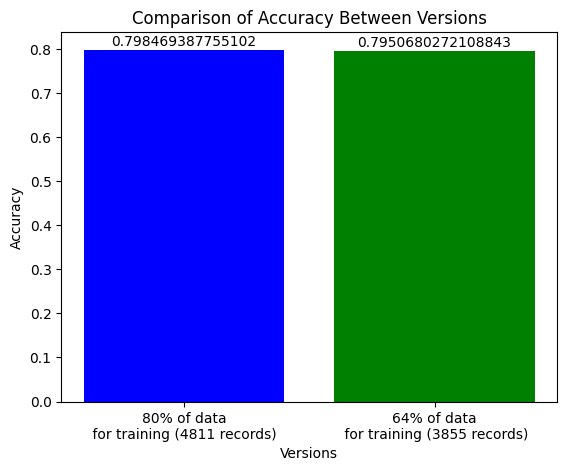

In [61]:
# To compare the ACCURACY of the Model
labels = ['80% of data\n for training (4811 records) ', '64% of data\n for training (3855 records)']
accuracies = [v1_accuracy, v2_accuracy]

x = np.arange(len(labels))

# Plotting the bar chart
plt.bar(x, accuracies, color=['blue', 'green'])

# Adding labels
plt.xlabel('Versions')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Between Versions')

# Adding value annotations on top of each bar
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, str(v), ha='center')

# Adding x-axis labels
plt.xticks(x, labels)

# Displaying the plot
plt.show()

<h3>2.2 Comparing Precision, Recall & F1-Score for Positive Sentiment</h3>

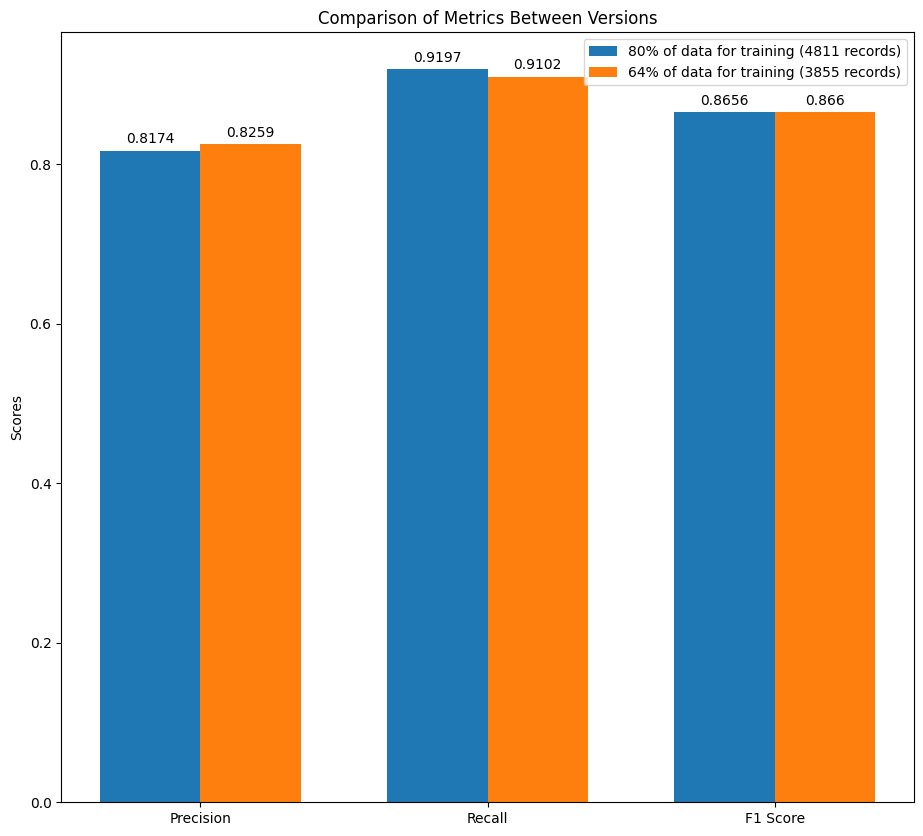

In [63]:
# To Compare the PRECISION, RECALL & F1-Score of the Model for Positive Sentiment Cases
v1_precision_0 = round(v1_precision_0, 4)
v1_recall_0 = round(v1_recall_0, 4)
v1_f1_score_0 = round(v1_f1_score_0, 4)

v2_precision_0 = round(v2_precision_0, 4)
v2_recall_0 = round(v2_recall_0, 4)
v2_f1_score_0 = round(v2_f1_score_0, 4)

# Labels
labels = ['Precision', 'Recall', 'F1 Score']
v1_metrics = [v1_precision_0, v1_recall_0, v1_f1_score_0]
v2_metrics = [v2_precision_0, v2_recall_0, v2_f1_score_0]
width = 0.35  # Width of the bars

x = np.arange(len(labels))

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(11, 10))
rects1 = ax.bar(x - width/2, v1_metrics, width, label='80% of data for training (4811 records)')
rects2 = ax.bar(x + width/2, v2_metrics, width, label='64% of data for training (3855 records)')

# Adding labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics Between Versions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value annotations on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Displaying the plot
plt.show()

<h3>2.3 Comparing Precision, Recall & F1-Score for Negative Sentiment</h3>

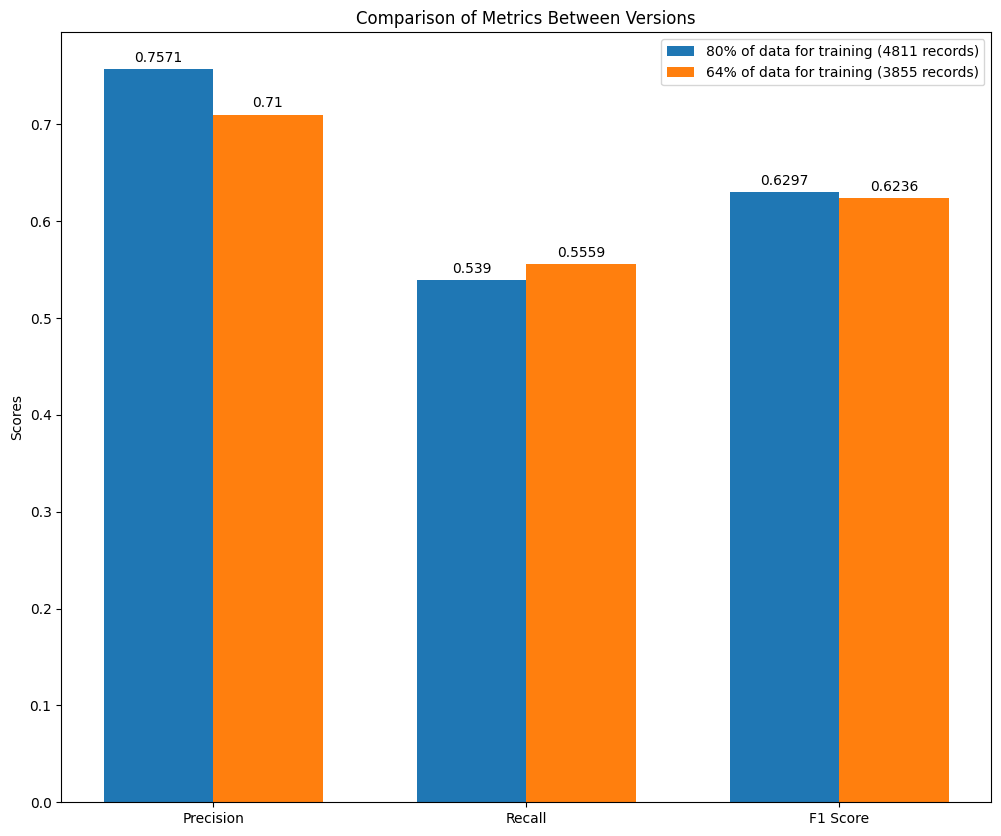

In [64]:
# To Compare the PRECISION, RECALL & F1-Score of the Model for Negative Sentiment Cases
v1_precision_1 = round(v1_precision_1, 4)
v1_recall_1 = round(v1_recall_1, 4)
v1_f1_score_1 = round(v1_f1_score_1, 4)

v2_precision_1 = round(v2_precision_1, 4)
v2_recall_1 = round(v2_recall_1, 4)
v2_f1_score_1 = round(v2_f1_score_1, 4)

# Labels
labels = ['Precision', 'Recall', 'F1 Score']
v1_metrics = [v1_precision_1, v1_recall_1, v1_f1_score_1]
v2_metrics = [v2_precision_1, v2_recall_1, v2_f1_score_1]
width = 0.35  # Width of the bars

x = np.arange(len(labels))

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 10))
rects1 = ax.bar(x - width/2, v1_metrics, width, label='80% of data for training (4811 records)')
rects2 = ax.bar(x + width/2, v2_metrics, width, label='64% of data for training (3855 records)')

# Adding labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics Between Versions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value annotations on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Displaying the plot
plt.show()

<h3>2.4 Comparing Precision, Recall & F1-Score for Neutral Sentiment</h3>

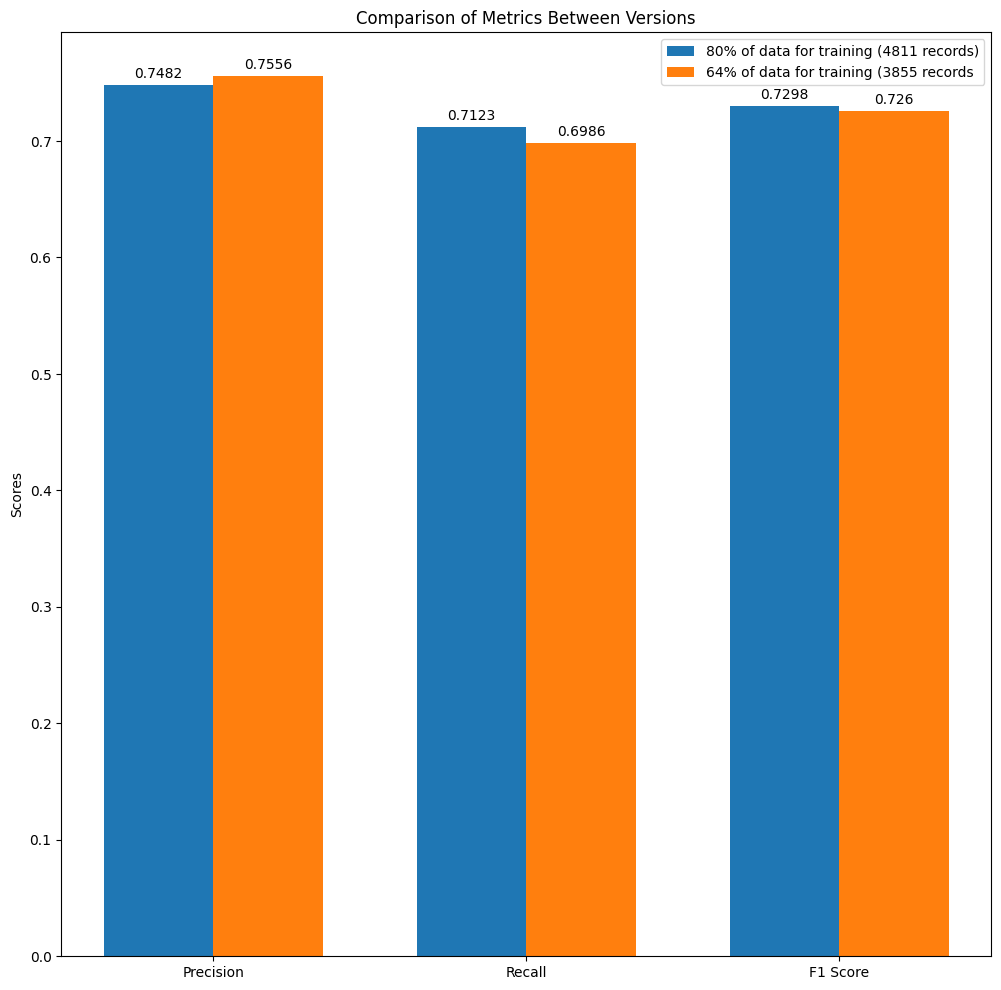

In [65]:
# To Compare the PRECISION, RECALL & F1-Score of the Model for Neutral Sentiment Cases
v1_precision_2 = round(v1_precision_2, 4)
v1_recall_2 = round(v1_recall_2, 4)
v1_f1_score_2 = round(v1_f1_score_2, 4)

v2_precision_2 = round(v2_precision_2, 4)
v2_recall_2 = round(v2_recall_2, 4)
v2_f1_score_2 = round(v2_f1_score_2, 4)

# Labels
labels = ['Precision', 'Recall', 'F1 Score']
v1_metrics = [v1_precision_2, v1_recall_2, v1_f1_score_2]
v2_metrics = [v2_precision_2, v2_recall_2, v2_f1_score_2]
width = 0.35  # Width of the bars

x = np.arange(len(labels))

# Plotting the grouped bar chart
fig, ax = plt.subplots(figsize=(12, 12))
rects1 = ax.bar(x - width/2, v1_metrics, width, label='80% of data for training (4811 records)')
rects2 = ax.bar(x + width/2, v2_metrics, width, label='64% of data for training (3855 records')

# Adding labels
ax.set_ylabel('Scores')
ax.set_title('Comparison of Metrics Between Versions')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding value annotations on top of each bar
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

# Displaying the plot
plt.show()

<h3>2.5 Displaying the Count for Each Sentiment Category (80% of data used for training)</h3>

In [103]:
import pandas as pd

prediction_df = spark.sql("SELECT prediction FROM prediction_result_view")
prediction_pd = prediction_df.toPandas()

In [104]:
label_mapping = {1: 'Negative', 0: 'Positive', 2: 'Neutral'}
prediction_pd['prediction'] = prediction_pd['prediction'].map(label_mapping)

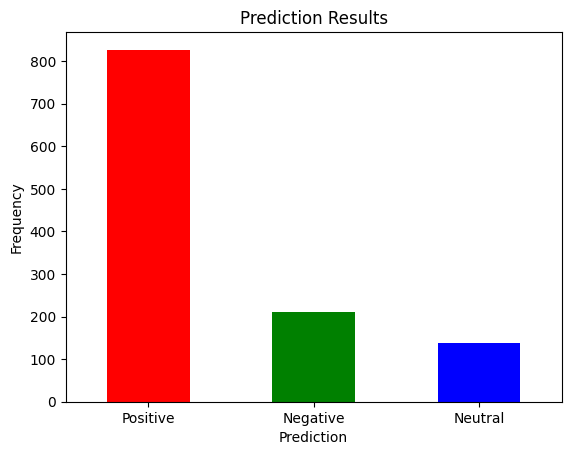

In [105]:
import matplotlib.pyplot as plt

# Count the occurrences of each prediction
prediction_counts = prediction_pd['prediction'].value_counts()

# Create a bar chart
prediction_counts.plot(kind='bar', color=['red', 'green', 'blue'])  # Optional: add colors for better distinction
plt.title('Prediction Results')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keeps the labels horizontal
plt.show()

<h3>2.6 Displaying the Count for Each Sentiment Category (64% of data used for training)</h3>

In [106]:
prediction_eva_df = spark.sql("SELECT prediction FROM prediction_result_eva_view")

# Convert to Pandas DataFrame
prediction_eva_pd = prediction_eva_df.toPandas()

In [107]:
label_mapping = {1: 'Negative', 0: 'Positive', 2: 'Neutral'}
prediction_eva_pd['prediction'] = prediction_eva_pd['prediction'].map(label_mapping)

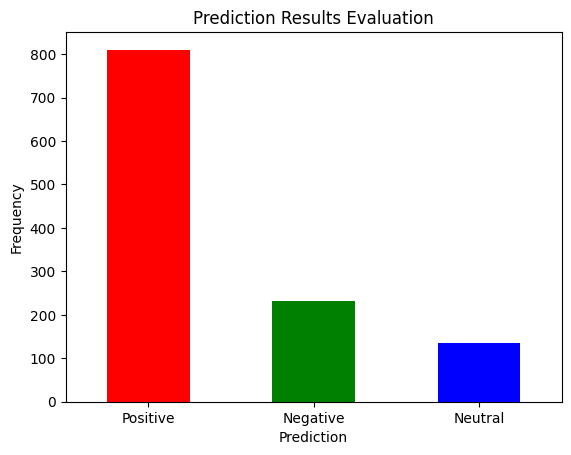

In [108]:
prediction_counts_eva = prediction_eva_pd['prediction'].value_counts()

# Create a bar chart
prediction_counts_eva.plot(kind='bar', color=['red', 'green', 'blue'])  # Adding colors for distinction
plt.title('Prediction Results Evaluation')
plt.xlabel('Prediction')
plt.ylabel('Frequency')
plt.xticks(rotation=0)  # Keeps the labels horizontal
plt.show()

<h3>2.7 Comparing the Count for Each Sentiment Category</h3>

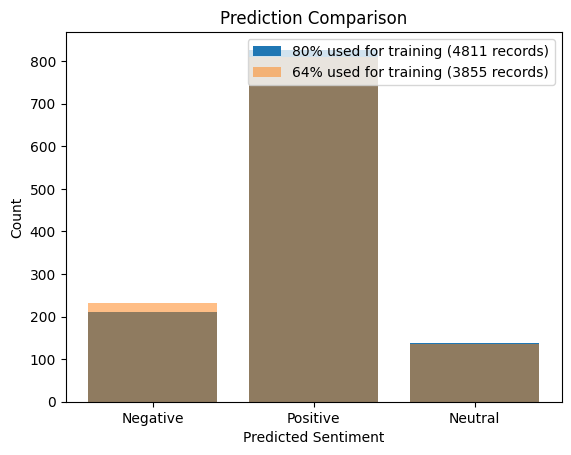

In [109]:
prediction_pd_counts = prediction_pd['prediction'].value_counts().reindex(label_mapping.values(), fill_value=0)

# Group and count occurrences for prediction_eva_pd
prediction_eva_pd_counts = prediction_eva_pd['prediction'].value_counts().reindex(label_mapping.values(), fill_value=0)

# Step 2: Create the bar chart
labels = label_mapping.values()

plt.bar(labels, prediction_pd_counts, label='80% used for training (4811 records)')
plt.bar(labels, prediction_eva_pd_counts, label='64% used for training (3855 records)', alpha=0.5)  # Making the second bars slightly transparent

# Add labels and legend
plt.xlabel('Predicted Sentiment')
plt.ylabel('Count')
plt.title('Prediction Comparison')
plt.legend()

plt.show()

<h3>2.8 Comparing the Count for Each Sentiment Category</h3>

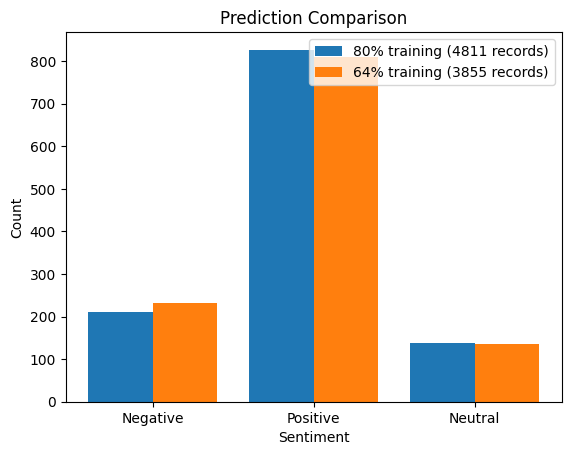

In [114]:
labels = list(label_mapping.values())

# Group and count occurrences for prediction_pd
prediction_pd_counts = prediction_pd['prediction'].value_counts().reindex(labels, fill_value=0)

# Group and count occurrences for prediction_eva_pd
prediction_eva_pd_counts = prediction_eva_pd['prediction'].value_counts().reindex(labels, fill_value=0)

# Step 2: Create the bar chart
x = range(len(labels))

plt.bar(x, prediction_pd_counts, width=0.4, label='80% training (4811 records)')
plt.bar([i + 0.4 for i in x], prediction_eva_pd_counts, width=0.4, label='64% training (3855 records)')

# Add labels and legend
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Prediction Comparison')
plt.xticks([i + 0.2 for i in x], labels)
plt.legend()

plt.show()

<h3>2.9 Comparing the Count for Each Sentiment Category</h3>

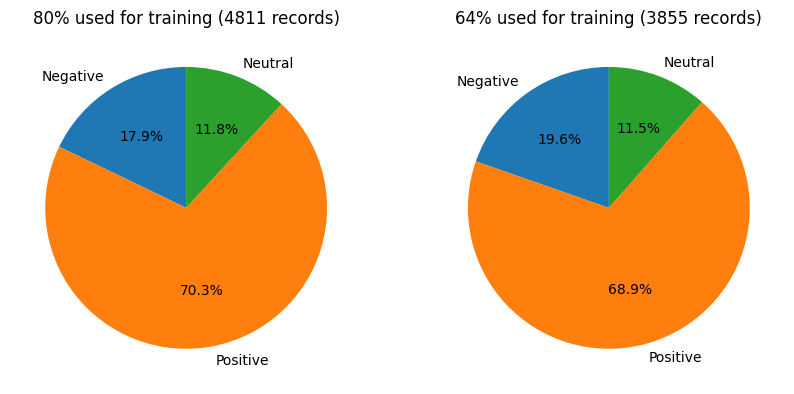

In [112]:
# Step 1: Prepare the data
labels = list(label_mapping.values())

# Calculate proportions for prediction_pd
prediction_pd_counts = prediction_pd['prediction'].value_counts().reindex(labels, fill_value=0)
total_pd = prediction_pd_counts.sum()
prediction_pd_proportions = prediction_pd_counts / total_pd

# Calculate proportions for prediction_eva_pd
prediction_eva_pd_counts = prediction_eva_pd['prediction'].value_counts().reindex(labels, fill_value=0)
total_eva_pd = prediction_eva_pd_counts.sum()
prediction_eva_pd_proportions = prediction_eva_pd_counts / total_eva_pd

# Step 2: Create the pie chart
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot pie chart for prediction_pd
ax[0].pie(prediction_pd_proportions, labels=labels, autopct='%1.1f%%', startangle=90)
ax[0].set_title('80% used for training (4811 records)')

# Plot pie chart for prediction_eva_pd
ax[1].pie(prediction_eva_pd_proportions, labels=labels, autopct='%1.1f%%', startangle=90)
ax[1].set_title('64% used for training (3855 records)')

plt.show()


In [66]:
spark.stop()